In [1]:
# 문장의 앞뒤에 시작과 끝을 알려주는 단어를 넣어주어 입력데이터 문제지와, 출력데이터 답안지를 만든다.

sentence = " 나는 밥을 먹었다 "

source_sentence = "<start>" + sentence
target_sentence = sentence + "<end>"

print("Source 문장:", source_sentence)
print("Target 문장:", target_sentence)

Source 문장: <start> 나는 밥을 먹었다 
Target 문장:  나는 밥을 먹었다 <end>


In [2]:
## 필요한 라이브러리
import os, re 
import numpy as np
import tensorflow as tf

# 파일을 읽기모드로 열고
# 라인 단위로 끊어서 list 형태로 읽어옵니다.
file_path = os.getenv('HOME') + '/aiffel/lyricist/data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()

# 앞에서부터 10라인만 화면에 출력해 볼까요?
print(raw_corpus[:9])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


In [3]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)
    
## 문장만 출력

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


In [4]:
## 토큰화 : 문장을 일정 기준을 쪼개는 것.

## 정제 함수
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


소스 문장(source sentence) : X_train

타겟 문장(Target Sentence) : y_train

문장 > 정제함수 > 토큰화 > 
- end 를 없에면 소스문장
- start 를 없에면 타겟문장

In [5]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

tf.keras.preprocessing.text.Tokenizer 패키지를 활용.

데이터를 토큰화 하고 단어사전을 만든다.

이를 벡터화(vectorize), 변화된 데이터를 텐서(tensor)라 한다.

In [6]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f1754d9fdf0>


In [11]:
print(tensor[:3, :10]) # 3행 10열 까지만 출력.

# 2로 시작 한다 ? start / 0으롤 채워진 부분 : 문장이 짧아 패딩이다. 0 : <pad>

[[   2  143   40  933  140  591    4  124   24  110]
 [   2  110    4  110    5    3    0    0    0    0]
 [   2   11   50   43 1201  316    9  201   74    9]]


In [10]:
#  tokenizer 에 구축된 단어사전 확인
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of


소스데이터와 타겟 데이터를 각각 end 와 start를 잘라서 만들자.

In [14]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0]) # 소스는 맨마지막이 잘리고,
print(tgt_input[0]) # 타겟은 앞의 start 가 잘림.

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


데이터셋 객체 생성하자.
- 보통은  model.fit(x_train, y_train, ...)  형태로 넘파이 배열 데이터셋을 생성하여 모델에 제공해왔다.
- 텐서플로를 활용할 경우 tf.data.Dataset 객체를 생성하는 방법을 흔히 사용함.
- 상기 객체는 텐서플로에서 사용할 경우, 입력 파이프라인(?)을 통한 속도 개선, 및 각종 편의 기능을 제공한다.
- tf.data.Dataset.from_tensor_slices()메서드를 통해 tf.data.Dataset객체를 생성하자.

In [15]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

데이터 전처리 : 지금 까지의 과정
 - 정규표현식으로 corpus 말뭉치 생성
 - tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환
 - tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환
 
 다듬기 끝,  tf.data.Dataset에서 제공하는 shuffle(), batch() 등  이용가능

***

임베딩 : 단어의 추상화 
- 차갑다: [0.0, 1.0]
- 뜨겁다: [1.0, 0.0]
- 미지근하다: [0.5, 0.5]



 tf.keras.Model을 Subclassing하는 방식으로 모델을 만들자.
 - 1개 임베딩 레이어
 - 2개  lstm 레이어
 - 1개 dense 레이어 로 구성
 
 

In [16]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):  # 단어 크기, 임베딩 크기, 히든 크기를 받는다.
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) # 임베딩 레이어
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True) # lstm 레이어 2개
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)                        # dense 레이어
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256 # 임베딩 크기 : 추상화 차원 
hidden_size = 1024 # 히든 크기
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

<상기 인자 설명>

__데이터가 충분치 않을때, 임베딩크기가 크면 오히려 혼란만 야기 할수 있다.__

이문제에서는 256이 적당해 보인다.

hidden state 의 hidden size : 모델이 얼마나 많은 일꾼을 둘 것인가? 일꾼은 모두 같은 데이터를 보고 각자 생각을 갖는다.

역시 충분한 데이터가 주어지지 않으면 배가 산으로 간다.

In [18]:
## 데이터 하나만 모델이 태워 보자.

# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[-2.95946695e-04,  1.66225596e-04, -5.90102572e-05, ...,
          3.50201095e-04,  2.12265135e-04, -2.08437283e-04],
        [-4.94624721e-04, -2.23441966e-04,  2.11170161e-04, ...,
          5.79748361e-04,  3.31729330e-04, -4.49428684e-04],
        [-7.99626054e-04, -4.01565136e-04,  3.28056427e-04, ...,
          5.28444652e-04,  1.34589165e-04, -5.45039307e-04],
        ...,
        [-9.81214573e-04, -5.75057406e-04, -5.39241191e-05, ...,
          5.72032935e-04,  7.07077328e-04, -3.33299139e-03],
        [-8.29434895e-04, -7.34498841e-04, -2.05637873e-04, ...,
          7.45653408e-04,  6.27283240e-04, -3.46248900e-03],
        [-6.64041610e-04, -8.90893687e-04, -3.48093599e-04, ...,
          8.94145225e-04,  5.53846767e-04, -3.56931426e-03]],

       [[-2.95946695e-04,  1.66225596e-04, -5.90102572e-05, ...,
          3.50201095e-04,  2.12265135e-04, -2.08437283e-04],
        [-6.12962351e-04,  5.49847144e-04,  1.

tf.Tensor: shape=(256, 20, 7001) 의 shape 이다.

- 7001 은 dense 층의 출력 차원수 이다.7001개의 단어중 확률이 어떤 단어의 확률이 가장 높을지 모델링한다.
- 256 은 지정한 배치사이즈 이다. dataset.take(1)을 통해 1개의 배치 즉 256개의 문장을 가져온것.
- 20 은 LSTM 레이어에서 return_sequences=True 라고 한 부분, 입력 시퀀스의 길이만큼 동일한 시퀀스를 출력한다는 뜻
- 만약 return_sequences=False 였다면 lstm 레이어는 1개의 벡터만 출력한다.
- 데이터셋의 max_len 을 20을 맞추면서, 스퀀스의 길이를 정해준것.


In [19]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


 모델 서머리 확인
 
- 파라미터 약 22밀리언


In [20]:
## 학습 시켜보자

# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=30)

Epoch 1/30
93/93 [==============================] - 22s 187ms/step - loss: 3.5059
Epoch 2/30
93/93 [==============================] - 18s 196ms/step - loss: 2.8132
Epoch 3/30
93/93 [==============================] - 19s 206ms/step - loss: 2.7315
Epoch 4/30
93/93 [==============================] - 19s 207ms/step - loss: 2.6382
Epoch 5/30
93/93 [==============================] - 19s 200ms/step - loss: 2.5655
Epoch 6/30
93/93 [==============================] - 18s 198ms/step - loss: 2.5150
Epoch 7/30
93/93 [==============================] - 19s 202ms/step - loss: 2.4679
Epoch 8/30
93/93 [==============================] - 19s 203ms/step - loss: 2.4149
Epoch 9/30
93/93 [==============================] - 19s 203ms/step - loss: 2.3693
Epoch 10/30
93/93 [==============================] - 19s 201ms/step - loss: 2.3295
Epoch 11/30
93/93 [==============================] - 19s 201ms/step - loss: 2.2881
Epoch 12/30
93/93 [==============================] - 19s 202ms/step - loss: 2.2484
Epoch 13/30
9

loss 는 모델이 오답을 만들고 있는 정도.(loss 가 1이라 하여, 99% 정답이라는 의미는 아니다.)
__loss가 적은 오답률이 적으니 만큼 학습이 잘 진행 되고 있다는 의미__

학습이 완료 되었으니 평가하자.

In [22]:
# 시작문장을 전달하면 시작문장을 바탕으로 작문을 진행.

def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [23]:
generate_text(model, tokenizer, init_sentence="<start> she")

'<start> she s not fourteen , and the earl of york <end> '

### 프로젝트 : 멋진 작사가 만들기.
***

##### 1. 데이터 준비
데이터 :  ~/aiffel/lyricist/data/lyrics 에있는 가사 데이터.

##### 2. 데이터 읽어 오기
- glob 활용, 모든 txt 읽어온후 raw_corpus 리스트에 문장 단위로 저장.


In [4]:
import glob
import os
import re 
import numpy as np
import tensorflow as tf

In [5]:


txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)  # 문장단위로 가사를 저장

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

#18만7천문장

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


##### 3. 데이터 정제
- 앞서 배운 내용으로 정제하자.
- 지나치게 긴문장은 과도한 패딩을 갖게함으로 제거하자.(너무 긴문장은 가사 작사에 어울리지 않을수도 있다.)
- 토큰화시 토큰수가 15개를 넘는 데이터는 제거하자.

In [6]:
# 전처리 함수. 특수문자 제거, 토크나이저 생성, 패딩처리
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() #     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2. 특수문자 양쪽에 공백을 넣고
    sentence = re.sub(r'[" "]+', " ", sentence) # 3. 여러개의 공백은 하나의 공백으로 바꿉니다
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
    sentence = sentence.strip() # 5. 다시 양쪽 공백을 지웁니다
    sentence = '<start> ' + sentence + ' <end>' # 6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
    return sentence

In [8]:
corpus = [] # 
for sentence in raw_corpus:
    # 원하지 않는 문장은 건너뛴다.
    if len(sentence) == 0 :
        continue
    #if sentence[-1] == ':':  # 이전 코드에서 : 대본 데이터 가 아니므로 필요 없다.
    #   continue
    
    # 정제하고 담아준다.
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15 : continue
    #    continue #15개가 넘어가는 문장 제외
          
    corpus.append(preprocessed_sentence)      
# 정제된 결과를 10개만 확인하자.
len(corpus[1:])
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

##### 4. 평가 데이터셋 분리.
- tokenize() 함수로 tensor 변환 후,
- sklearn 모듈의 train_test_split() 함수로 분리
- 12000 이상 크기 단어장, 20% 의 평가 데이터셋

In [9]:
def tokenize(corpus):
    # 프로젝트 조건대로 12천개 단어로 설정.
    # 12000 단어에 포함되지 못한 단어는 <unk> 으로 바꾼다.
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words = 12000,
        filters = ' ',
        oov_token = "<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다.
    tokenizer.fit_on_texts(corpus)
    #준비한 tokenizer를 이용해 corpus를 tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)
    # 입력 데이터의 시퀀스 길이를 일정하게
    # 짧다면, 문장 뒤에 패딩.
    # 문장앞에 패딩을 붙이고 싶다면 padding= 'pre'
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,  padding='post')  
    
    print(tensor, tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성
tgt_input = tensor[:, 1:] 

from sklearn.model_selection import train_test_split

# 프로젝트 조건제로 20프로 평가 데이터셋,
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2, 
                                                          shuffle=True, 
                                                          random_state=34)

[[   2   50    4 ...    0    0    0]
 [   2   15 2971 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  117 ...    0    0    0]
 [   2  258  195 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f8c882bca90>


##### 5. 인공지능 만들기
- Embedding Size와 Hidden Size를 조절
- 10 Epoch 안에 val_loss 값을 2.2 수준의 모델 설계!
- 제시된 Loss 함수 그대로 사용.

In [10]:
VOCAB_SIZE = tokenizer.num_words + 1   
# 모델 구성
class TextGenerator(tf.keras.Model):
    def __init__ (self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        return out  
    
# Loss, 제시된 loss 함수
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [11]:
# 
embedding_size = 256 # 조절할 파라미터
hidden_size = 1024 # 조절할 파라미터
lyricist = TextGenerator(VOCAB_SIZE, embedding_size, hidden_size) # 모델객체 만들기.

optimizer = tf.keras.optimizers.Adam() # 옵티마이저 아담.



In [14]:
# 학습
lyricist.compile(loss=loss, optimizer=optimizer)
lyricist.fit(enc_train,dec_train,
             validation_data = (enc_val, dec_val),
             epochs=10) # 프로젝트 조건 에폭 10으로

Epoch 1/10
3906/3906 [==============================] - 151s 37ms/step - loss: 3.0755 - val_loss: 2.8128
Epoch 2/10
3906/3906 [==============================] - 144s 37ms/step - loss: 2.6493 - val_loss: 2.6103
Epoch 3/10
3906/3906 [==============================] - 144s 37ms/step - loss: 2.3705 - val_loss: 2.4916
Epoch 4/10
3906/3906 [==============================] - 144s 37ms/step - loss: 2.1186 - val_loss: 2.4153
Epoch 5/10
3906/3906 [==============================] - 144s 37ms/step - loss: 1.8984 - val_loss: 2.3717
Epoch 6/10
3906/3906 [==============================] - 144s 37ms/step - loss: 1.7098 - val_loss: 2.3500
Epoch 7/10
3906/3906 [==============================] - 144s 37ms/step - loss: 1.5508 - val_loss: 2.3504
Epoch 8/10
3906/3906 [==============================] - 144s 37ms/step - loss: 1.4196 - val_loss: 2.3577
Epoch 9/10
3906/3906 [==============================] - 144s 37ms/step - loss: 1.3142 - val_loss: 2.3794
Epoch 10/10
3906/3906 [==============================] 

In [30]:
print()
print(lyricist.history.history['loss'])
print(lyricist.history.history['val_loss'])
print('min_loss : ', min(lyricist.history.history['loss']))
print('min_val_loss : ', min(lyricist.history.history['val_loss']))

[3.0754616260528564, 2.6493139266967773, 2.3704731464385986, 2.1185572147369385, 1.8983515501022339, 1.7097548246383667, 1.5508168935775757, 1.4196193218231201, 1.3141851425170898, 1.2294940948486328]
[2.8127739429473877, 2.6103031635284424, 2.4915597438812256, 2.41528058052063, 2.371746301651001, 2.3500263690948486, 2.350421667098999, 2.357670545578003, 2.3794145584106445, 2.409083366394043]
min_loss :  1.2294940948486328
min_val_loss :  2.3500263690948486


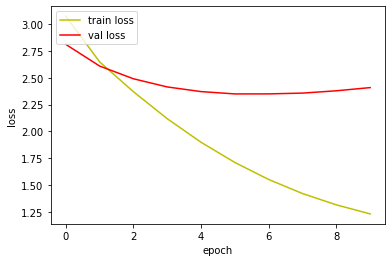

In [33]:
# loss, val_loss 추이 살펴보기

import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()


loss_ax.plot(lyricist.history.history['loss'], 'y', label='train loss')
loss_ax.plot(lyricist.history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')


plt.show()

##### 결과
- loss 는 꾸준히 감소하는 형태로 학습되어 최종 및 최소 1.2295 이다.
- val_loss 는 전체적으로 감소하는 추세이나, 에폭 후반부에서 2.3 과 2.4 사이 이다.
- val_loss 는 최종 2.4091, 최소 2.3500 이다.
- val_loss 는 에폭 6 이후부터 최소 2.3500 을 찍고 다시 증가하고 있다.반면 loss는 꾸준히 증가한다.
- 에폭 6이후 과적합되고 있다고 해석된다.

In [23]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [24]:
# 모델로 작곡 해보기.
generate_text(lyricist, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you , i love you , i love you <end> '

#### 텍스트 제네레이션 결과
- 'i love you , i love you , i love you '
- 후렴구 같은 문장이 생성 되었다.

### 개선해보자.
- 상기 까지의 코드는 프로젝트에서 제안된 방향으로만 진행된 코드이다.
- 그 결과  va_loss 는 최소 2.3500 이었다.
-

- 시도 가능한 방법은 다음과 같다.
1. embedding_size, hidden_size를 조절하여 loss를 개선해보라 했다. 그리드 서치르 통해 두 값을 변화 하여 시도 해보자.

2. 전처리 함수의 개선점은 없을까?

3. 여러 가수가 있는데 왜 랜덤하게 셔플하지?

##### 1. embedding_size, hidden_size 그리드 서치 해보자.

Epoch 1/10
3906/3906 [==============================] - 65s 16ms/step - loss: 3.1878 - val_loss: 2.9317
Epoch 2/10
3906/3906 [==============================] - 61s 16ms/step - loss: 2.8172 - val_loss: 2.7831
Epoch 3/10
3906/3906 [==============================] - 61s 16ms/step - loss: 2.6447 - val_loss: 2.7006
Epoch 4/10
3906/3906 [==============================] - 61s 16ms/step - loss: 2.5027 - val_loss: 2.6518
Epoch 5/10
3906/3906 [==============================] - 61s 16ms/step - loss: 2.3828 - val_loss: 2.6274
Epoch 6/10
3906/3906 [==============================] - 61s 16ms/step - loss: 2.2798 - val_loss: 2.6162
Epoch 7/10
3906/3906 [==============================] - 61s 16ms/step - loss: 2.1900 - val_loss: 2.6078
Epoch 8/10
3906/3906 [==============================] - 61s 16ms/step - loss: 2.1097 - val_loss: 2.6011
Epoch 9/10
3906/3906 [==============================] - 61s 16ms/step - loss: 2.0362 - val_loss: 2.5957
Epoch 10/10
3906/3906 [==============================] - 61s 16m

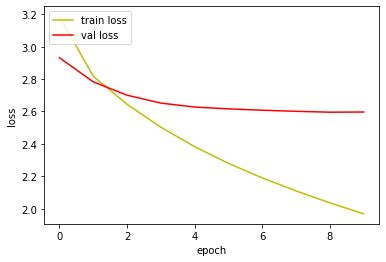

e0h0 DONE
Epoch 1/10
3906/3906 [==============================] - 145s 36ms/step - loss: 3.0968 - val_loss: 2.8351
Epoch 2/10
3906/3906 [==============================] - 142s 36ms/step - loss: 2.6769 - val_loss: 2.6427
Epoch 3/10
3906/3906 [==============================] - 142s 36ms/step - loss: 2.4066 - val_loss: 2.5196
Epoch 4/10
3906/3906 [==============================] - 142s 36ms/step - loss: 2.1595 - val_loss: 2.4444
Epoch 5/10
3906/3906 [==============================] - 142s 36ms/step - loss: 1.9407 - val_loss: 2.3939
Epoch 6/10
3906/3906 [==============================] - 142s 36ms/step - loss: 1.7508 - val_loss: 2.3669
Epoch 7/10
3906/3906 [==============================] - 142s 36ms/step - loss: 1.5890 - val_loss: 2.3648
Epoch 8/10
3906/3906 [==============================] - 141s 36ms/step - loss: 1.4555 - val_loss: 2.3643
Epoch 9/10
3906/3906 [==============================] - 141s 36ms/step - loss: 1.3460 - val_loss: 2.3858
Epoch 10/10
3906/3906 [======================

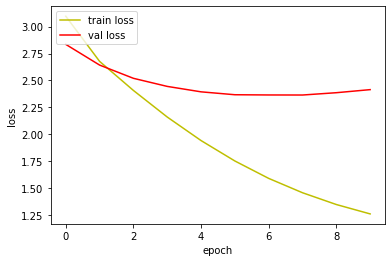

e0h1 DONE
Epoch 1/10
3906/3906 [==============================] - 447s 110ms/step - loss: 2.9872 - val_loss: 2.7042
Epoch 2/10
3906/3906 [==============================] - 431s 110ms/step - loss: 2.4731 - val_loss: 2.4562
Epoch 3/10
3906/3906 [==============================] - 432s 111ms/step - loss: 2.0541 - val_loss: 2.3164
Epoch 4/10
3906/3906 [==============================] - 432s 111ms/step - loss: 1.7171 - val_loss: 2.2542
Epoch 5/10
3906/3906 [==============================] - 432s 111ms/step - loss: 1.4723 - val_loss: 2.2462
Epoch 6/10
3906/3906 [==============================] - 432s 111ms/step - loss: 1.3060 - val_loss: 2.2717
Epoch 7/10
3906/3906 [==============================] - 431s 110ms/step - loss: 1.2006 - val_loss: 2.3207
Epoch 8/10
3906/3906 [==============================] - 430s 110ms/step - loss: 1.1365 - val_loss: 2.3554
Epoch 9/10
3906/3906 [==============================] - 432s 111ms/step - loss: 1.0945 - val_loss: 2.3903
Epoch 10/10
3906/3906 [=============

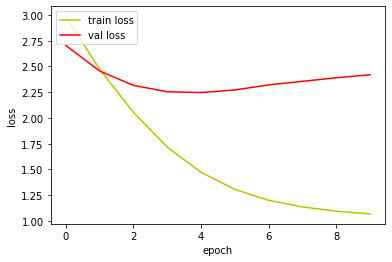

e0h2 DONE
Epoch 1/10
3906/3906 [==============================] - 68s 17ms/step - loss: 3.1571 - val_loss: 2.9032
Epoch 2/10
3906/3906 [==============================] - 65s 17ms/step - loss: 2.7858 - val_loss: 2.7552
Epoch 3/10
3906/3906 [==============================] - 65s 17ms/step - loss: 2.6002 - val_loss: 2.6671
Epoch 4/10
3906/3906 [==============================] - 65s 17ms/step - loss: 2.4477 - val_loss: 2.6242
Epoch 5/10
3906/3906 [==============================] - 65s 17ms/step - loss: 2.3188 - val_loss: 2.5981
Epoch 6/10
3906/3906 [==============================] - 65s 17ms/step - loss: 2.2074 - val_loss: 2.5859
Epoch 7/10
3906/3906 [==============================] - 65s 17ms/step - loss: 2.1104 - val_loss: 2.5782
Epoch 8/10
3906/3906 [==============================] - 65s 17ms/step - loss: 2.0237 - val_loss: 2.5772
Epoch 9/10
3906/3906 [==============================] - 65s 17ms/step - loss: 1.9455 - val_loss: 2.5729
Epoch 10/10
3906/3906 [==============================]

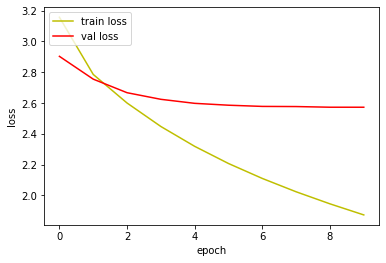

e1h0 DONE
Epoch 1/10
3906/3906 [==============================] - 149s 37ms/step - loss: 3.0869 - val_loss: 2.8344
Epoch 2/10
3906/3906 [==============================] - 144s 37ms/step - loss: 2.6780 - val_loss: 2.6431
Epoch 3/10
3906/3906 [==============================] - 145s 37ms/step - loss: 2.4151 - val_loss: 2.5224
Epoch 4/10
3906/3906 [==============================] - 145s 37ms/step - loss: 2.1768 - val_loss: 2.4516
Epoch 5/10
3906/3906 [==============================] - 145s 37ms/step - loss: 1.9649 - val_loss: 2.4065
Epoch 6/10
3906/3906 [==============================] - 145s 37ms/step - loss: 1.7775 - val_loss: 2.3768
Epoch 7/10
3906/3906 [==============================] - 145s 37ms/step - loss: 1.6141 - val_loss: 2.3718
Epoch 8/10
3906/3906 [==============================] - 145s 37ms/step - loss: 1.4768 - val_loss: 2.3778
Epoch 9/10
3906/3906 [==============================] - 145s 37ms/step - loss: 1.3619 - val_loss: 2.3943
Epoch 10/10
3906/3906 [======================

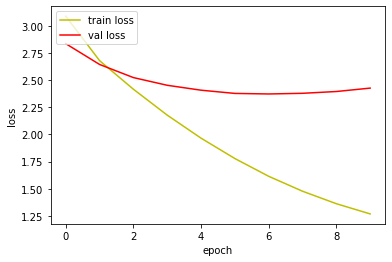

e1h1 DONE
Epoch 1/10
3906/3906 [==============================] - 452s 111ms/step - loss: 2.9612 - val_loss: 2.6729
Epoch 2/10
3906/3906 [==============================] - 434s 111ms/step - loss: 2.4216 - val_loss: 2.4204
Epoch 3/10
3906/3906 [==============================] - 434s 111ms/step - loss: 1.9889 - val_loss: 2.2762
Epoch 4/10
3906/3906 [==============================] - 434s 111ms/step - loss: 1.6454 - val_loss: 2.2216
Epoch 5/10
3906/3906 [==============================] - 434s 111ms/step - loss: 1.4056 - val_loss: 2.2248
Epoch 6/10
3906/3906 [==============================] - 434s 111ms/step - loss: 1.2492 - val_loss: 2.2504
Epoch 7/10
3906/3906 [==============================] - 434s 111ms/step - loss: 1.1560 - val_loss: 2.2934
Epoch 8/10
3906/3906 [==============================] - 434s 111ms/step - loss: 1.1024 - val_loss: 2.3338
Epoch 9/10
3906/3906 [==============================] - 434s 111ms/step - loss: 1.0696 - val_loss: 2.3674
Epoch 10/10
3906/3906 [=============

In [ ]:
# 그리드 서치할 파라미터를 기존 값에서 각각 절반, 2배 해주었다. 총 9개의 loss를 확인 할수 있을 것이다.
# 2제곱수로 값을 정한이유(램덤서치를 하지 않은 이유) : 메모리 사용에서 2의 제곱수를 사용하는 것이 일반적으로 더 좋은 효율을
# batch size 의 경우 GPU의 물리적인 구조로 인해 2의 제곱으로 한다고 한다.
embedding_size_list = [128, 256, 512]
hidden_size_list = [512,1024, 2048]

# 간단한 for문으로 그리드 서치를 구현하자.
result_loss = {} 
#결과 loss 값만 담을 리스트 초기화 (loss, val_loss) 의 값을 그리드 서치할 값 리스트의 인덱스에 대응하게 2차원 리스트에 넣자.

for i, embedding_size in enumerate(embedding_size_list) : 
    for j, hidden_size in enumerate(hidden_size_list):
        
        lyricist = TextGenerator(VOCAB_SIZE, embedding_size, hidden_size) # 모델객체 만들기.
        optimizer = tf.keras.optimizers.Adam() # 옵티마이저 아담.
        lyricist.compile(loss=loss, optimizer=optimizer)
        # 학습하기
        lyricist.fit(enc_train,dec_train,
                     validation_data = (enc_val, dec_val),
                     epochs=10) # 프로젝트 조건 에폭 10으로
        
        # 학습후 loss, val_loss 저장하기.
        print(lyricist.history.history['loss'])
        print(lyricist.history.history['val_loss'])
        print('min_loss : ', min(lyricist.history.history['loss']))
        print('min_val_loss : ', min(lyricist.history.history['val_loss']))
        key = 'e' + str(i)+'h'+str(j)
        
        result_loss[key]= lyricist.history.history
        fig, loss_ax = plt.subplots()


        loss_ax.plot(lyricist.history.history['loss'], 'y', label='train loss')
        loss_ax.plot(lyricist.history.history['val_loss'], 'r', label='val loss')
        loss_ax.set_xlabel('epoch')
        loss_ax.set_ylabel('loss')
        loss_ax.legend(loc='upper left')


        plt.show()
        
        print(key, "DONE")

- 주피터 연결이 끊어져 e2h0~2 의 세 경우는 loss 를 확인하지 못했다.

e0h0 :
min_loss :  1.967924952507019
min_val_loss :  2.5956761837005615

e0h1 :
min_loss :  1.2586865425109863
min_val_loss :  2.3642728328704834

e0h2 :
min_loss :  1.0683977603912354
min_val_loss :  2.246192693710327

***
e1h0 :
min_loss :  1.8736133575439453
min_val_loss :  2.572798013687134

e1h1 :
min_loss :  1.2680233716964722
min_val_loss :  2.3717541694641113

e1h2 :
min_loss :  1.0480512380599976
min_val_loss :  2.221614360809326
***

- 부족한 데이터이긴 하지만 몇가지 경향을 확인 할수 있었다.
- embedding size 의 증가는 뚜렸한, val_loss 의 증가를 보여주지 않았다.
- hidden size 의 증가는 val_loss 를 뚜렸하게 증가했다. 
- e0 : 2.59 > 2.36 > 2,24
- e1 : 2.57 > 2.37 > 2.22
- e2 : 학습하지 못함.


#### 결론
- 따라서 e1으로 기존 256의 embedding size를 유지하고,
- h2 로 2048 의 hidden size를 각각 하이퍼파라미터 조절 하자.

제출시간이 없어 간단한 회고
 - 아쉬운점 제출 시간이 조급해 아쉽다.
 - 다음부터 미리하자
 - 임베딩과 히든을 꼭 2배수로 할필요는 없을것 같다. gpu 관련은 찾아보니 배치 사이즈와 관렸이 있다.
 - 꼭 추후 자료 추가하겠다.

루브릭

1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?

텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?

2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?

특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?

3. 텍스트 생성모델이 안정적으로 학습되었는가?

텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?